<a href="https://colab.research.google.com/github/sn0422j/notebook/blob/master/PRML11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from base64 import b64encode

## 棄却サンプリング

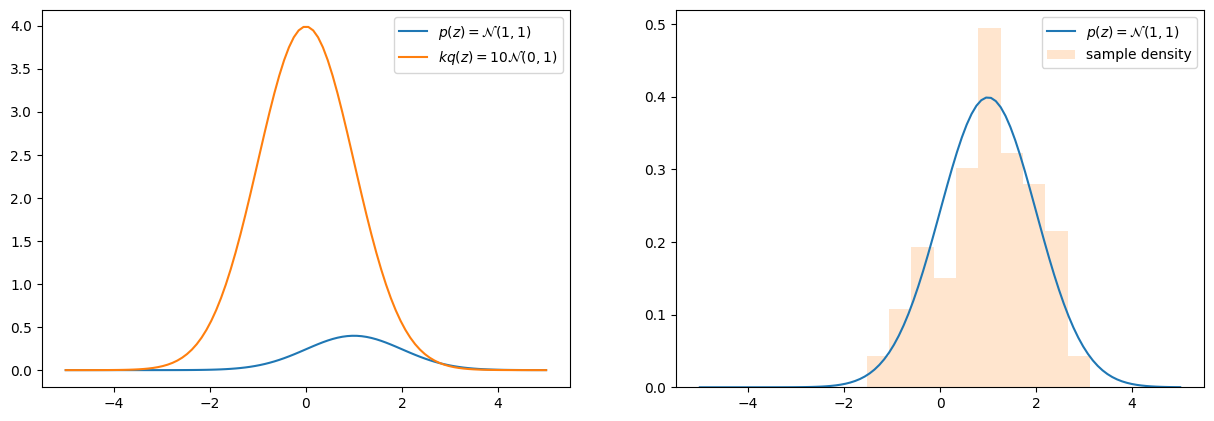

In [ ]:
def rejection_sampling(p, q, *, k, num_sample=100, seed=1234, max_iteration=1000):
    np.random.seed(seed)
    sample_list = []
    for _ in range(max_iteration):
        z0 = q.rvs()
        u0 = np.random.rand() * k * q.pdf(z0)
        if u0 <= p.pdf(z0):
            sample_list.append(z0)
            if len(sample_list) == num_sample: break
    return np.asarray(sample_list)

def demo():
    p = stats.norm(loc=1, scale=1)
    q = stats.norm(loc=0, scale=1)
    samples = rejection_sampling(p, q, k=10)
    
    # plot
    x = np.linspace(-5, 5, 100)
    f, ax = plt.subplots(1,2, figsize=(15,5), dpi=100)
    ax[0].plot(x, p.pdf(x), label=r"$p(z)=\mathcal{N}(1,1)$")
    ax[0].plot(x, 10 * q.pdf(x), label=r"$kq(z)=10\mathcal{N}(0,1)$")
    ax[0].legend()
    ax[1].plot(x, p.pdf(x), label=r"$p(z)=\mathcal{N}(1,1)$")
    ax[1].hist(samples, density=True, alpha=0.2, label=r"sample density")
    ax[1].legend()

demo()

In [ ]:
def animation_rejection_sampling(*, num_sample=100, seed=1234, max_iteration=1000):
    p = stats.norm(loc=1, scale=1)
    q = stats.norm(loc=0, scale=1)
    k = 10
    np.random.seed(seed)

    x = np.linspace(-5, 5, 100)
    fig, ax = plt.subplots(1,1, figsize=(8,5), dpi=100)
    ax.plot(x, p.pdf(x), c="b", label=r"$p(z)=\mathcal{N}(1,1)$")
    ax.set_ylim(0,1)
    sample_list = []; img_list = []
    for i in range(max_iteration):
        z0 = q.rvs()
        u0 = np.random.rand() * k * q.pdf(z0)
        if u0 <= p.pdf(z0):
            sample_list.append(z0)
            _, _, img = ax.hist(sample_list, density=True, color="orange", alpha=0.2, label=r"sample density")
            if len(sample_list)==1: ax.legend()
            img_list.append(img)
            if len(sample_list) == num_sample: break
    
    ani = animation.ArtistAnimation(fig, img_list)
    ani.save("rejection_sampling.mp4", writer="ffmpeg")
    plt.close(fig)
    
def show(mp4_file):
    mp4 = open(mp4_file, 'rb').read()
    data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
    return HTML(f"""
    <video width="50%" height="50%" controls>
        <source src="{data_url}" type="video/mp4">
    </video>""")

animation_rejection_sampling()
show("rejection_sampling.mp4")

## SIR (sampling_importance_resampling)

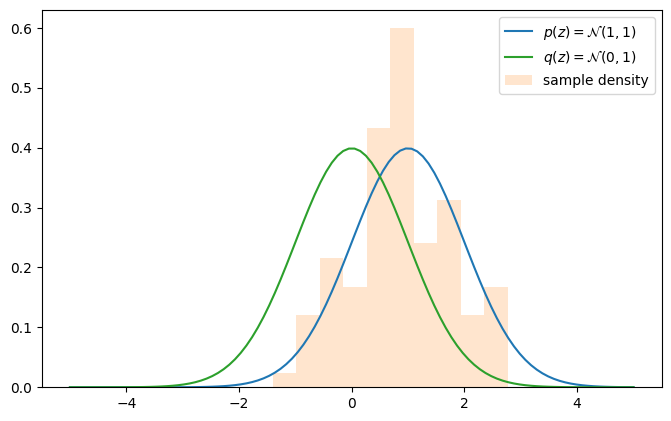

In [ ]:
def sampling_importance_resampling(p, q, *, num_sample=100, seed=1234, max_iteration=1000):
    np.random.seed(seed)
    sample_array = q.rvs(size=max_iteration)
    r = np.squeeze(p.pdf(sample_array) / q.pdf(sample_array))
    w = r/np.sum(r)
    index = np.random.choice(max_iteration, size=num_sample, p=w)
    return sample_array[index]

def demo():
    p = stats.norm(loc=1, scale=1)
    q = stats.norm(loc=0, scale=1)
    samples = sampling_importance_resampling(p, q)
    
    # plot
    x = np.linspace(-5, 5, 100)
    f, ax = plt.subplots(1,1, figsize=(8,5), dpi=100)
    ax.plot(x, p.pdf(x), label=r"$p(z)=\mathcal{N}(1,1)$")
    ax.hist(samples, density=True, alpha=0.2, label=r"sample density")
    ax.plot(x, q.pdf(x), label=r"$q(z)=\mathcal{N}(0,1)$")
    ax.legend()

demo()

## メトロポリス・ヘイスティングス法

$Q(z^*|z) = \mathcal{N}(z^*|z,1)$ を用いる。

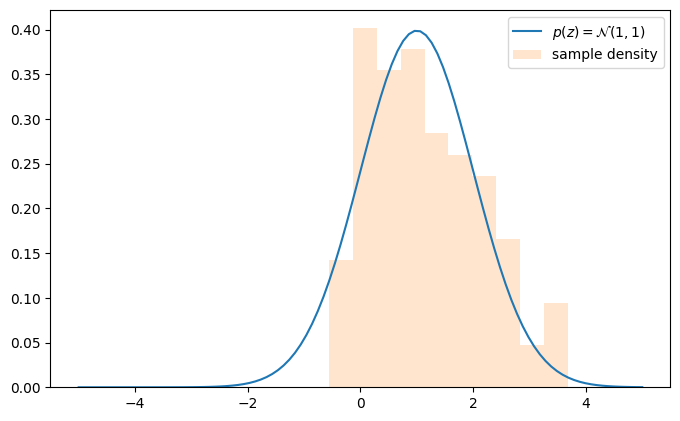

In [ ]:
def metropolis_hastings(p, q, *, num_sample=100, seed=1234, max_iteration=1000):
    np.random.seed(seed)
    z_temp = 0; sample_list = []
    for _ in range(max_iteration):
        z_star = q.conditional_rvs(z_temp)
        accept_proba = min(1, ( p.pdf(z_star) * q.conditional_pdf(z_temp, z_star) ) / ( p.pdf(z_temp) * q.conditional_pdf(z_star, z_temp) ))
        if np.random.rand() < accept_proba:
            z_temp = z_star
            sample_list.append(z_temp)
            if len(sample_list) == num_sample: break
    return np.asarray(sample_list)

class Q:
    def __init__(self):
        self.q = stats.norm
    def conditional_rvs(self, loc: float) -> float:
        return self.q.rvs(loc=loc)
    def conditional_pdf(self, x:float, loc: float) -> float:
        return self.q.pdf(x, loc=loc)

def demo():
    p = stats.norm(loc=1, scale=1)
    q = Q()
    samples = metropolis_hastings(p, q)
    
    # plot
    x = np.linspace(-5, 5, 100)
    f, ax = plt.subplots(1,1, figsize=(8,5), dpi=100)
    ax.plot(x, p.pdf(x), label=r"$p(z)=\mathcal{N}(1,1)$")
    ax.hist(samples, density=True, alpha=0.2, label=r"sample density")
    ax.legend()

demo()

In [ ]:
def animation_metropolis_hastings(*, num_sample=100, seed=1234, max_iteration=1000):
    p = stats.norm(loc=1, scale=1)
    q = Q()
    np.random.seed(seed)
    
    x = np.linspace(-5, 5, 100)
    fig, ax = plt.subplots(1,1, figsize=(8,5), dpi=100)
    ax.plot(x, p.pdf(x), c="b", label=r"$p(z)=\mathcal{N}(1,1)$")
    ax.set_ylim(0,1)
    z_temp = 0; sample_list = []; img_list = []
    for _ in range(max_iteration):
        z_star = q.conditional_rvs(z_temp)
        accept_proba = min(1, ( p.pdf(z_star) * q.conditional_pdf(z_temp, z_star) ) / ( p.pdf(z_temp) * q.conditional_pdf(z_star, z_temp) ))
        if np.random.rand() < accept_proba:
            z_temp = z_star
            sample_list.append(z_temp)
            _, _, img = ax.hist(sample_list, density=True, color="orange", alpha=0.2, label=r"sample density")
            if len(sample_list)==1: ax.legend()
            img_list.append(img)
            if len(sample_list) == num_sample: break
    
    ani = animation.ArtistAnimation(fig, img_list)
    ani.save("metropolis_hastings.mp4", writer="ffmpeg")
    plt.close(fig)

animation_metropolis_hastings()
show("metropolis_hastings.mp4")

## ギブズサンプリング
2次元ガウス分布をサンプリングする。

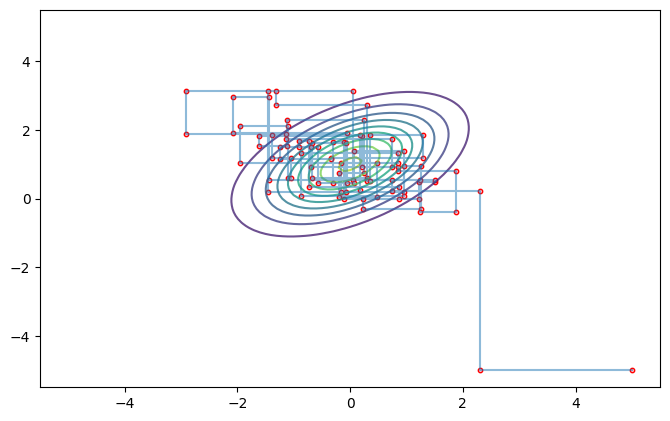

In [ ]:
def gibbs_sampling(q, *, num_sample=100, seed=1234):
    np.random.seed(seed)
    z = np.asarray([5., -5.]); sample_list = [z.copy()]
    for _ in range(num_sample//2):
        z[0] = q.conditional_rvs(z[1], 1)
        sample_list.append(z.copy())
        z[1] = q.conditional_rvs(z[0], 0)
        sample_list.append(z.copy())
    return np.asarray(sample_list)

class Q:
    def __init__(self, mu=[0., 1.], sigma=[[1., 0.5], [0.5, 1.]], alpha=0.5, relax=False):
        self.p = stats.multivariate_normal
        self.mu = np.asarray(mu)
        self.sigma = np.asarray(sigma)
        self.alpha = alpha
        self.relax = relax
    
    def pdf(self, x):
        return self.p.pdf(x, mean=self.mu, cov=self.sigma)
    
    def rvs(self, size):
        return self.p.rvs(mean=self.mu, cov=self.sigma, size=size)
    
    def conditional_rvs(self, x, conditional_index):
        sample_index = 1- conditional_index
        mu_ = self.mu[sample_index] -  (self.sigma[sample_index, conditional_index]) * ((self.sigma[conditional_index, conditional_index])**(-1)) * (x - self.mu[conditional_index])
        sigma_ = self.sigma[sample_index, sample_index] - self.sigma[sample_index, conditional_index] *  ((self.sigma[conditional_index, conditional_index])**(-1)) * self.sigma[conditional_index, sample_index]
        if self.relax:
            return self.over_relaxation(self.p.rvs(mean=mu_, cov=sigma_), mu_, sigma_)        
        return self.p.rvs(mean=mu_, cov=sigma_)
    
    def over_relaxation(self, z, mu, sigma):
        nu = np.random.normal(0,1)
        return mu + self.alpha * (z - mu) + np.sqrt(sigma * (1 - (self.alpha)**2)) * nu 

def demo():
    q = Q(relax=True)
    samples = gibbs_sampling(q)

    # plot
    fig, ax = plt.subplots(1,1, figsize=(8,5), dpi=100)
    x, y =np.meshgrid(np.arange(-5, 5, 0.1), np.arange(-5, 5, 0.1))
    z = np.asarray([
        [q.pdf(np.asarray([x[j,i],y[j,i]])) for i in range(len(x))] 
        for j in range(len(x))
    ])
    ax.contour(x, y, z, levels=10, alpha=0.8)    
    ax.scatter(samples[:, 0], samples[:, 1], s=10, c="pink", edgecolor="red")
    ax.plot(samples[:, 0], samples[:, 1], alpha=0.5)
    ax.set_xlim(-5.5,5.5); ax.set_ylim(-5.5,5.5)

demo()

In [ ]:
def animation_gibbs_sampling():
    q = Q(relax=True)
    samples = gibbs_sampling(q)

    # plot
    fig, ax = plt.subplots(1,1, figsize=(8,5), dpi=100)
    x, y =np.meshgrid(np.arange(-5, 5, 0.1), np.arange(-5, 5, 0.1))
    z = np.asarray([
        [q.pdf(np.asarray([x[j,i],y[j,i]])) for i in range(len(x))] 
        for j in range(len(x))
    ])
    ax.contour(x, y, z, levels=10, alpha=0.8)    
    ax.set_xlim(-5.5,5.5); ax.set_ylim(-5.5,5.5)
    img_list = []
    for i in range(len(samples)):
        img = ax.plot(samples[:i, 0], samples[:i, 1], alpha=0.5, c="blue")
        img_list.append(img)
    
    ani = animation.ArtistAnimation(fig, img_list)
    ani.save("gibbs_sampling.mp4", writer="ffmpeg")
    plt.close(fig)

animation_gibbs_sampling()
show("gibbs_sampling.mp4")

## ハイブリッド・モンテカルロ法

https://kefism.hatenablog.com/entry/2017/03/14/231005

https://qiita.com/kenmatsu4/items/71141e0249c266c1b653#%E3%83%AA%E3%83%BC%E3%83%97%E3%83%95%E3%83%AD%E3%83%83%E3%82%B0%E6%B3%95

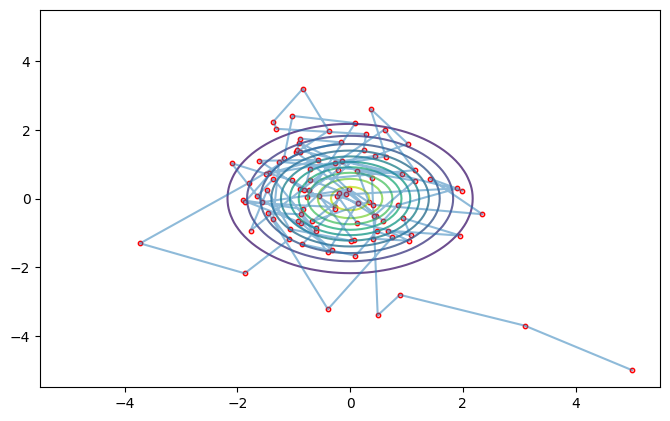

In [ ]:
def hamiltonian(z, r, sigma):
    def E(z, sigma):
        return (1/2) * np.sum((1/sigma**(2)) * (z**2))
    def K(r):
        return (1/2) * np.sum(r**2)
    return E(z, sigma) + K(r)

def leapfrog(z_i, r_i, sigma_i, epsilon = 0.01, L = 100):
    def dE(z_i, sigma_i):
        return z_i/(sigma_i ** 2)
    for _ in range(L):
        r_i = r_i - (epsilon/2) * dE(z_i, sigma_i)
        z_i = z_i + epsilon * r_i
        r_i = r_i - (epsilon/2) * dE(z_i, sigma_i)
    return z_i, r_i

def hybridMCMC(z_start, sigma, *, num_sample=100, seed=1234, max_iteration=1000):
    np.random.seed(seed)
    z_temp = np.asarray(z_start)
    sigma = np.asarray(sigma)
    sample_list = [z_temp]
    z_star = z_temp.copy()
    for _ in range(max_iteration):
        r_temp = stats.multivariate_normal(mean=[0., 0.], cov=[1., 1.]).rvs()
        r_star = r_temp.copy()
        for i in range(len(z_temp)):
            if np.random.rand() > 0.5:
                epsilon = 0.01
            else:
                epsilon = -0.01
            for i in range(len(z_temp)):
                z_star[i], r_star[i] = leapfrog(z_temp[i], r_temp[i], sigma[i], epsilon)
        accept_proba = min(1, np.exp( hamiltonian(z_temp, r_temp, sigma) - hamiltonian(z_star, r_star, sigma) ))
        if np.random.rand() < accept_proba:
            z_temp = z_star.copy()
            sample_list.append(z_temp)
        if len(sample_list) == num_sample: break
    return np.asarray(sample_list)

def demo():
    sigma = [1., 1.]
    p = stats.multivariate_normal(mean=[0., 0.], cov=sigma)

    z_start = [5., -5.]
    samples = hybridMCMC(z_start, sigma, num_sample=100)

    # plot
    fig, ax = plt.subplots(1,1, figsize=(8,5), dpi=100)
    x, y =np.meshgrid(np.arange(-5, 5, 0.1), np.arange(-5, 5, 0.1))
    z = np.asarray([
        [p.pdf(np.asarray([x[j,i],y[j,i]])) for i in range(len(x))] 
        for j in range(len(x))
    ])
    ax.contour(x, y, z, levels=10, alpha=0.8)    
    ax.scatter(samples[:, 0], samples[:, 1], s=10, c="pink", edgecolor="red")
    ax.plot(samples[:, 0], samples[:, 1], alpha=0.5)
    ax.set_xlim(-5.5,5.5); ax.set_ylim(-5.5,5.5)

demo()

In [ ]:
def animation_hybridMCMC():
    sigma = [1., 1.]
    p = stats.multivariate_normal(mean=[0., 0.], cov=sigma)

    z_start = [5., -5.]
    samples = hybridMCMC(z_start, sigma, num_sample=100)

    # plot
    fig, ax = plt.subplots(1,1, figsize=(8,5), dpi=100)
    x, y =np.meshgrid(np.arange(-5, 5, 0.1), np.arange(-5, 5, 0.1))
    z = np.asarray([
        [p.pdf(np.asarray([x[j,i],y[j,i]])) for i in range(len(x))] 
        for j in range(len(x))
    ])
    ax.contour(x, y, z, levels=10, alpha=0.8)    
    ax.set_xlim(-5.5,5.5); ax.set_ylim(-5.5,5.5)
    img_list = []
    for i in range(len(samples)):
        img = ax.plot(samples[:i, 0], samples[:i, 1], alpha=0.5, c="blue")
        img_list.append(img)
    
    ani = animation.ArtistAnimation(fig, img_list)
    ani.save("hybridMCMC.mp4", writer="ffmpeg")
    plt.close(fig)

animation_hybridMCMC()
show("hybridMCMC.mp4")